In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline  
from subprocess import check_output
print(check_output(["ls","."]).decode("utf8") )                  

italy_earthquakes.ipynb
italy_earthquakes_from_2016-08-24_to_2016-11-30.csv



In [35]:
df=pd.read_csv('italy_earthquakes_from_2016-08-24_to_2016-11-30.csv')
df.head(10)

,Time,Latitude,Longitude,Depth/Km,Magnitude
0,2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
1,2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2,2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
3,2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
4,2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6
5,2016-08-24 03:43:58.700,42.7298,13.2137,10.7,3.4
6,2016-08-24 03:44:38.660,42.6760,13.2858,10.8,2.7
7,2016-08-24 03:44:56.400,42.6282,13.2648,10.6,3.2
8,2016-08-24 03:46:12.240,42.7645,13.1777,6.6,3.7
9,2016-08-24 03:46:46.000,42.7445,13.2097,12.4,2.8


In [41]:
# Read the dataset
df = pd.read_csv('italy_earthquakes_from_2016-08-24_to_2016-11-30.csv').set_index('Time')
df.index = pd.to_datetime(df.index)
df.head()

,Latitude,Longitude,Depth/Km,Magnitude
Time,,,,
2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6


In [42]:
df.describe()

,Latitude,Longitude,Depth/Km,Magnitude
count,8086.000000,8086.000000,8086.000000,8086.000000
mean,42.829557,13.161034,9.968328,2.398368
std,0.125927,0.083058,2.194064,0.426381
min,41.581300,12.537700,0.200000,2.000000
25%,42.751350,13.103200,8.900000,2.100000
50%,42.821800,13.160700,9.900000,2.300000
75%,42.911000,13.215650,10.800000,2.600000
max,43.927300,13.852500,47.900000,6.500000


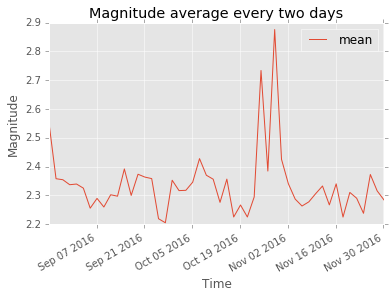

In [43]:
df["Magnitude"].resample("2D").apply([np.mean]).plot()
plt.title("Magnitude average every two days")
plt.ylabel("Magnitude")

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

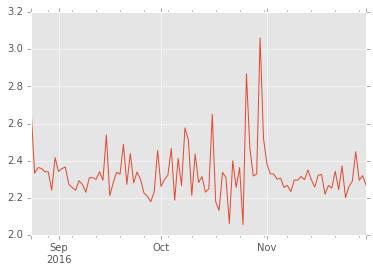

In [46]:
df["Magnitude"].resample("D").apply([np.mean]).plot()
plt.title("Magnitude average every day")
plt.ylabel("Magnitude")

In [49]:
mag3=df.ix[df["Magnitude"] >= 3.0, "Magnitude"]

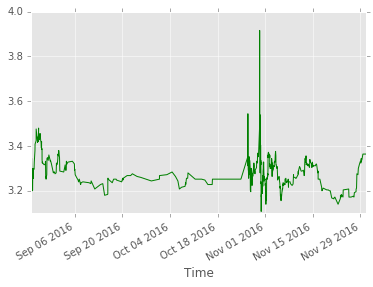

In [51]:
pd.Series.rolling(mag3,window=25).mean().plot(style="-g")

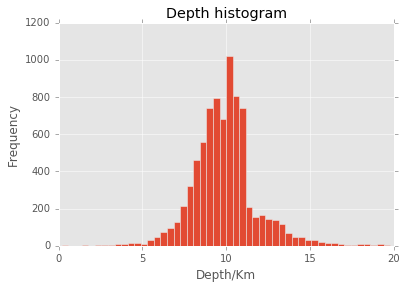

In [55]:
plt.figure()
depth=df[(df['Depth/Km']<20) & (df["Depth/Km"] >= 0)]["Depth/Km"]
depth.plot(kind="hist", stacked=True, bins=50)

plt.title("Depth histogram")
plt.xlabel("Depth/Km")


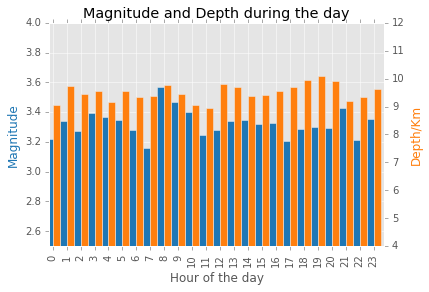

In [70]:
depth_mgn=df.where((df['Magnitude']>=3.0)).dropna()[['Magnitude','Depth/Km']]
dm=depth_mgn.groupby(depth_mgn.index.hour).mean()
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_ylim([2.5,4])
ax.set_ylabel("Magnitude")
ax.set_xlabel("Hour of the day")
ax.yaxis.label.set_color("#1f77b4")

ax2=ax.twinx()
ax2.set_ylim([4.0, 12])
ax2.set_ylabel("Depth/Km")
ax2.set_xlabel("Hour of the day")
ax2.yaxis.label.set_color("#ff7f0e")
width = 0.5

dm["Magnitude"].plot(kind="bar", color='#1f77b4', ax=ax, width=width, position=1)
dm["Depth/Km"].plot(kind="bar", color="#ff7f0e", ax=ax2, width=width, position=0)

plt.grid(False)
plt.title("Magnitude and Depth during the day")

In [63]:
depth_mgn.head()

,Magnitude,Depth/Km
Time,,
2016-08-24 03:36:32.000,6.0,8.1
2016-08-24 03:37:26.580,4.5,9.0
2016-08-24 03:40:46.590,3.8,9.7
2016-08-24 03:41:38.900,3.9,9.7
2016-08-24 03:42:07.170,3.6,9.7


In [71]:
# This function is taken from here:
# https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

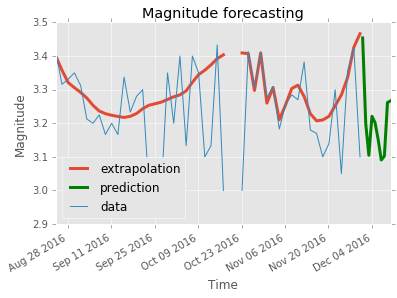

In [75]:
n_predict = 300
resample_period = "2D"
predict_period = "D"

pred = pd.Series(
    fourierExtrapolation(mag3, n_predict),
    index=mag3.index.append(pd.DatetimeIndex(start="2016-12-01", freq="45T", periods=n_predict))
)

fig = plt.figure()

fitted = pred[:-n_predict].resample(resample_period).mean()
predict = pred[-n_predict:].resample(predict_period).mean()

fitted.plot(linewidth=3, label="extrapolation")
predict.plot(linewidth=3, style="-g", label="prediction")
mag3.resample(resample_period).mean().plot(label="data")

plt.title("Magnitude forecasting")
plt.ylabel("Magnitude")
plt.legend(loc="lower left")

In [76]:
print (df.head(10))


                         Latitude  Longitude  Depth/Km  Magnitude
Time                                                             
2016-08-24 03:36:32.000   42.6983    13.2335       8.1        6.0
2016-08-24 03:37:26.580   42.7123    13.2533       9.0        4.5
2016-08-24 03:40:46.590   42.7647    13.1723       9.7        3.8
2016-08-24 03:41:38.900   42.7803    13.1683       9.7        3.9
2016-08-24 03:42:07.170   42.7798    13.1575       9.7        3.6
2016-08-24 03:43:58.700   42.7298    13.2137      10.7        3.4
2016-08-24 03:44:38.660   42.6760    13.2858      10.8        2.7
2016-08-24 03:44:56.400   42.6282    13.2648      10.6        3.2
2016-08-24 03:46:12.240   42.7645    13.1777       6.6        3.7
2016-08-24 03:46:46.000   42.7445    13.2097      12.4        2.8
